In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


# Load API keys - search in multiple locations
def find_secrets():
    """Find secrets.json in current dir, parent dir, or submodules dir."""
    possible_paths = [
        "../secrets.json",  # Parent directory (markets/)
    ]
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✓ Found secrets at: {path}")
            return path
    raise FileNotFoundError(
        "secrets.json not found. Searched locations:\n" + "\n".join(f"  - {p}" for p in possible_paths)
    )

SECRET_FP = find_secrets()
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

# Import from package (works if installed with pip install -e .)
try:
    from markets.submodules import Chain, ChainHistory, Security, Index
    from markets.submodules.fa import FundamentalAnalysis
    from markets.submodules import plot
    from markets.submodules.plot import ChartStyle
    print("✓ Using installed markets package")
except ImportError:
    print("⚠ Package not installed, using local imports")
    
    # Try to find the submodules directory
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    
    # Check for markets/submodules (if we're in markets/implementations)
    submodules_path = os.path.join(parent_dir, 'submodules')
    
    if os.path.exists(submodules_path):
        sys.path.insert(0, submodules_path)
        print(f"  Added to path: {submodules_path}")
    
    from eodhd import Chain, ChainHistory, Security, Index
    import plot
    from plot import ChartStyle

cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)


✓ Found secrets at: ../secrets.json
⚠ Package not installed, using local imports
  Added to path: c:\Users\msands\OneDrive\Documents\code\markets\submodules


# Chain

In [2]:
chain = Chain(ticker = 'IVV', max_expiration="2026-01-31")
calls = chain.calls
puts = chain.puts
atm = chain.atm
atm_calls = chain.atm_calls
atm_puts = chain.atm_puts
d25 = chain.delta_twenty_five
chain.get_atm_avg()

Total records to fetch: 1570
Fetched 1000 rows at offset 0
Fetched 570 rows at offset 1000


,exp_date,volatility_call,volatility_put,volatility_avg
0,2025-12-12,0.1481,0.1158,0.13195
1,2025-12-19,0.1209,0.1586,0.13975
2,2025-12-26,0.1278,0.1434,0.13560
3,2026-01-02,0.1274,0.1374,0.13240
4,2026-01-09,0.1320,0.1436,0.13780
5,2026-01-16,0.1463,0.1483,0.14730
6,2026-01-23,0.1408,0.1409,0.14085


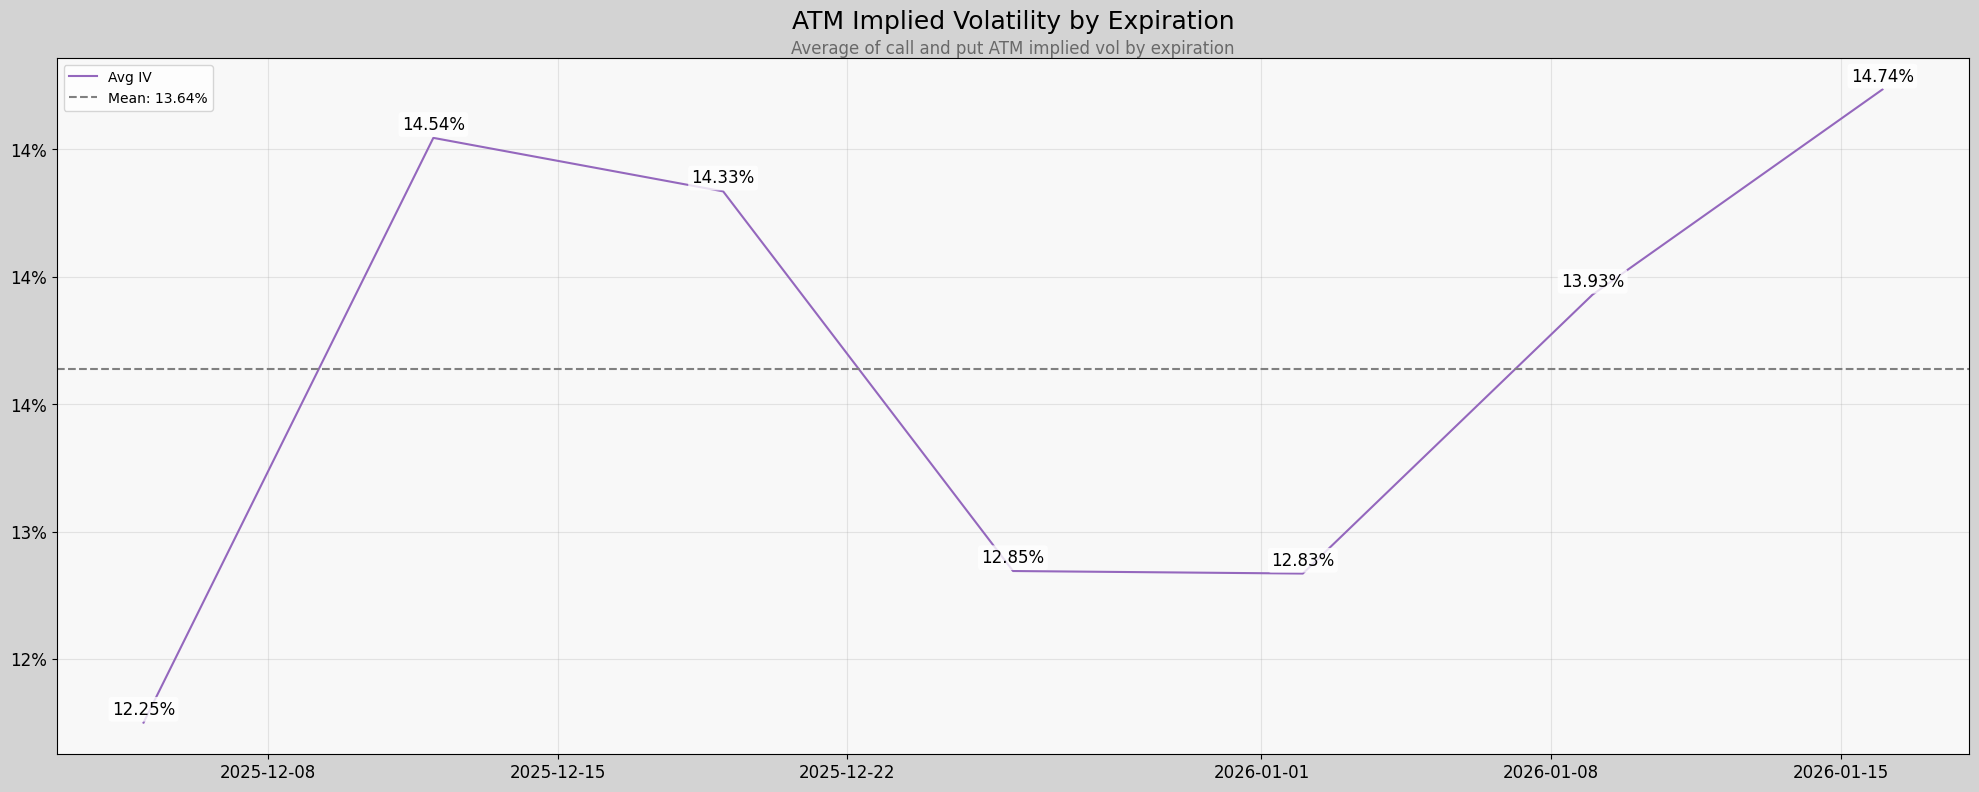

In [37]:
res = atm_calls.merge(atm_puts, on='exp_date', suffixes=('_call', '_put'), how='inner', validate='one_to_one', indicator=True)[['exp_date', 'volatility_call', 'volatility_put']]
res['ivol'] = (res['volatility_call'] + res['volatility_put']) / 2

res = atm_calls.merge(
    atm_puts,
    on='exp_date',
    suffixes=('_call', '_put'),
    how='inner',
    validate='one_to_one',
    indicator=True
)[['exp_date', 'volatility_call', 'volatility_put']].copy()
res['exp_date'] = pd.to_datetime(res['exp_date'])
res = res.sort_values('exp_date')
res['ivol'] = (res['volatility_call'] + res['volatility_put']) / 2

# single-line plot of the average (ivol)
ax = plot.plot_line(
    x=res['exp_date'],
    y=res['ivol'],
    date_axis=False,
    style=cs,
    title="ATM Implied Volatility by Expiration",
    subtitle="Average of call and put ATM implied vol by expiration",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="Avg IV",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    color="tab:purple",
)


for x, y in zip(res['exp_date'], res['ivol']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                # color='tab:blue',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))


ax.axhline(y=res['ivol'].mean(), color='gray', linestyle='--', label=f'Mean: {res["ivol"].mean():.2%}')
ax.legend()

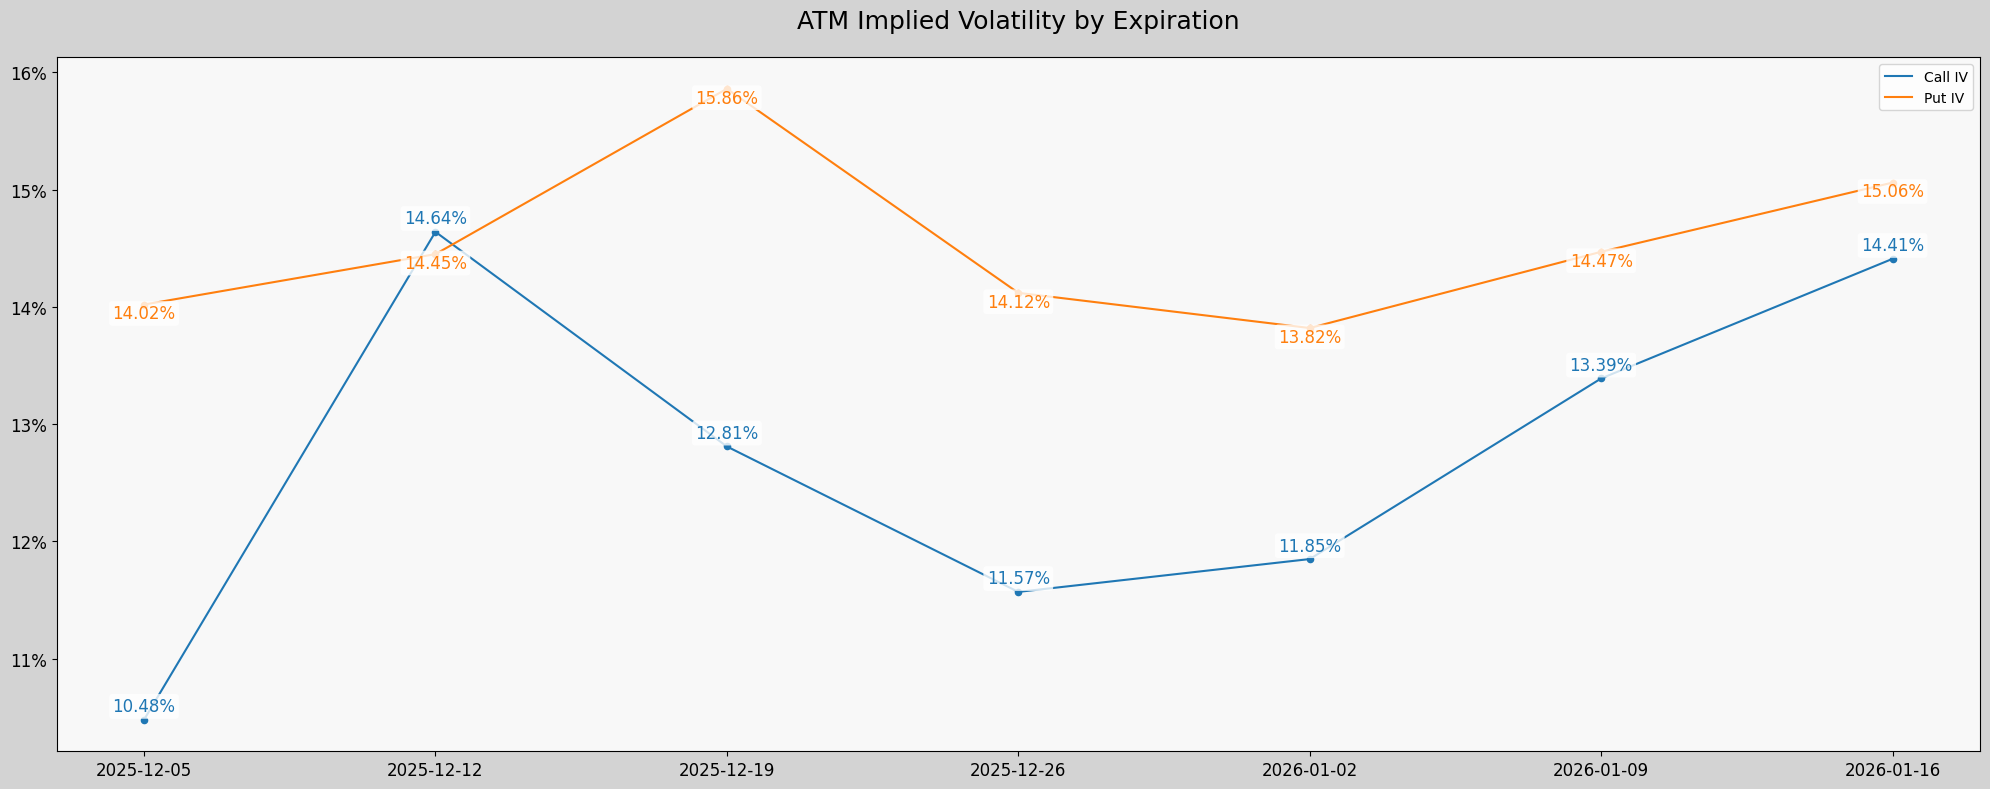

In [38]:

ax = plot.plot_line(
    x=atm_calls['exp_date'],
    y=atm_calls['volatility'],
    date_axis=False,
    style=cs,
    title="ATM Implied Volatility by Expiration",
    subtitle="",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="Call IV",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)

plot.plot_line(
    x=atm_puts['exp_date'],
    y=atm_puts['volatility'],
    ax=ax,
    date_axis=False,
    style=cs,
    label="Put IV",
    color="tab:orange",
    annotate_last=False,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)

ax.scatter(atm_calls['exp_date'], atm_calls['volatility'], color='tab:blue', s=20, zorder=3)
ax.scatter(atm_puts['exp_date'], atm_puts['volatility'], color='tab:orange', s=20, zorder=3)

for x, y in zip(atm_calls['exp_date'], atm_calls['volatility']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                color='tab:blue',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

for x, y in zip(atm_puts['exp_date'], atm_puts['volatility']):
    ax.annotate(f"{y:.2%}",
                xy=(x, y),
                xytext=(0, -10),
                textcoords="offset points",
                ha="center",
                fontsize=12,
                color='tab:orange',
                zorder=4,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

ax.legend()

In [39]:
chain.get_implied_move()

type,exp_date,dte,call,put,ivol,undr_last_price,expected_move_usd,expected_move_pct
0,2025-12-05,2,0.1048,0.1402,0.12250,687.26,6.231975,0.009068
1,2025-12-12,9,0.1464,0.1445,0.14545,687.26,15.696745,0.022840
2,2025-12-19,16,0.1281,0.1586,0.14335,687.26,20.626822,0.030013
3,2025-12-26,23,0.1157,0.1412,0.12845,687.26,22.160148,0.032244
4,2026-01-02,30,0.1185,0.1382,0.12835,687.26,25.288970,0.036797
5,2026-01-09,37,0.1339,0.1447,0.13930,687.26,30.480818,0.044351
6,2026-01-16,44,0.1441,0.1506,0.14735,687.26,35.160182,0.051160


In [40]:
display(puts.exp_date.sort_values().unique())
cols_display = ['contract', 'exp_date', 'strike', 'bid','ask', 'midpoint', 'last','theoretical', 'volatility','delta','gamma', 'theta', 'vega', 'rho',]
EXP_DATE = '2025-12-26'

array(['2025-12-05', '2025-12-12', '2025-12-19', '2025-12-26',
       '2026-01-02', '2026-01-09', '2026-01-16'], dtype=object)

In [41]:
puts_sub = puts[puts['exp_date'] == EXP_DATE].copy()[cols_display]
puts_sub = puts_sub[(puts_sub['delta'] >= -0.5) & (puts_sub['delta'] <= -0.1)]
puts_sub = puts_sub[puts_sub['strike'].notna() & np.isclose(puts_sub['strike'] % 5, 0)].copy()
puts_sub

,contract,exp_date,strike,bid,ask,midpoint,last,theoretical,volatility,delta,gamma,theta,vega,rho
274,IVV251226P00620000,2025-12-26,620.0,0.00,3.0,1.50,0.00,3.00,0.3411,-0.103197,0.003053,-0.224733,0.309737,-0.042997
275,IVV251226P00625000,2025-12-26,625.0,0.00,3.0,1.50,0.00,3.00,0.3218,-0.108455,0.003355,-0.219439,0.321062,-0.045070
278,IVV251226P00640000,2025-12-26,640.0,0.20,3.9,2.05,4.50,2.05,0.2351,-0.103448,0.004439,-0.153756,0.310270,-0.042453
279,IVV251226P00645000,2025-12-26,645.0,0.45,4.0,2.23,7.30,2.23,0.2219,-0.116208,0.005114,-0.157285,0.337283,-0.047560
280,IVV251226P00650000,2025-12-26,650.0,1.05,4.5,2.78,3.33,2.77,0.2177,-0.141296,0.005970,-0.176277,0.386295,-0.057657
284,IVV251226P00655000,2025-12-26,655.0,1.30,2.8,2.05,15.40,2.05,0.1790,-0.130084,0.006866,-0.135991,0.365029,-0.052891
289,IVV251226P00660000,2025-12-26,660.0,2.00,4.7,3.35,7.60,3.35,0.1902,-0.183409,0.008109,-0.180875,0.457834,-0.073828
294,IVV251226P00665000,2025-12-26,665.0,2.00,5.2,3.60,9.50,3.60,0.1736,-0.208706,0.009613,-0.177330,0.495168,-0.083625
299,IVV251226P00670000,2025-12-26,670.0,3.00,6.1,4.55,12.32,4.55,0.1684,-0.255688,0.011105,-0.191411,0.554401,-0.101343
305,IVV251226P00675000,2025-12-26,675.0,4.10,7.5,5.80,25.50,5.80,0.1644,-0.311812,0.012525,-0.203939,0.609642,-0.121967


In [42]:
puts_sub[puts_sub['strike']==640]

,contract,exp_date,strike,bid,ask,midpoint,last,theoretical,volatility,delta,gamma,theta,vega,rho
278,IVV251226P00640000,2025-12-26,640.0,0.2,3.9,2.05,4.5,2.05,0.2351,-0.103448,0.004439,-0.153756,0.31027,-0.042453


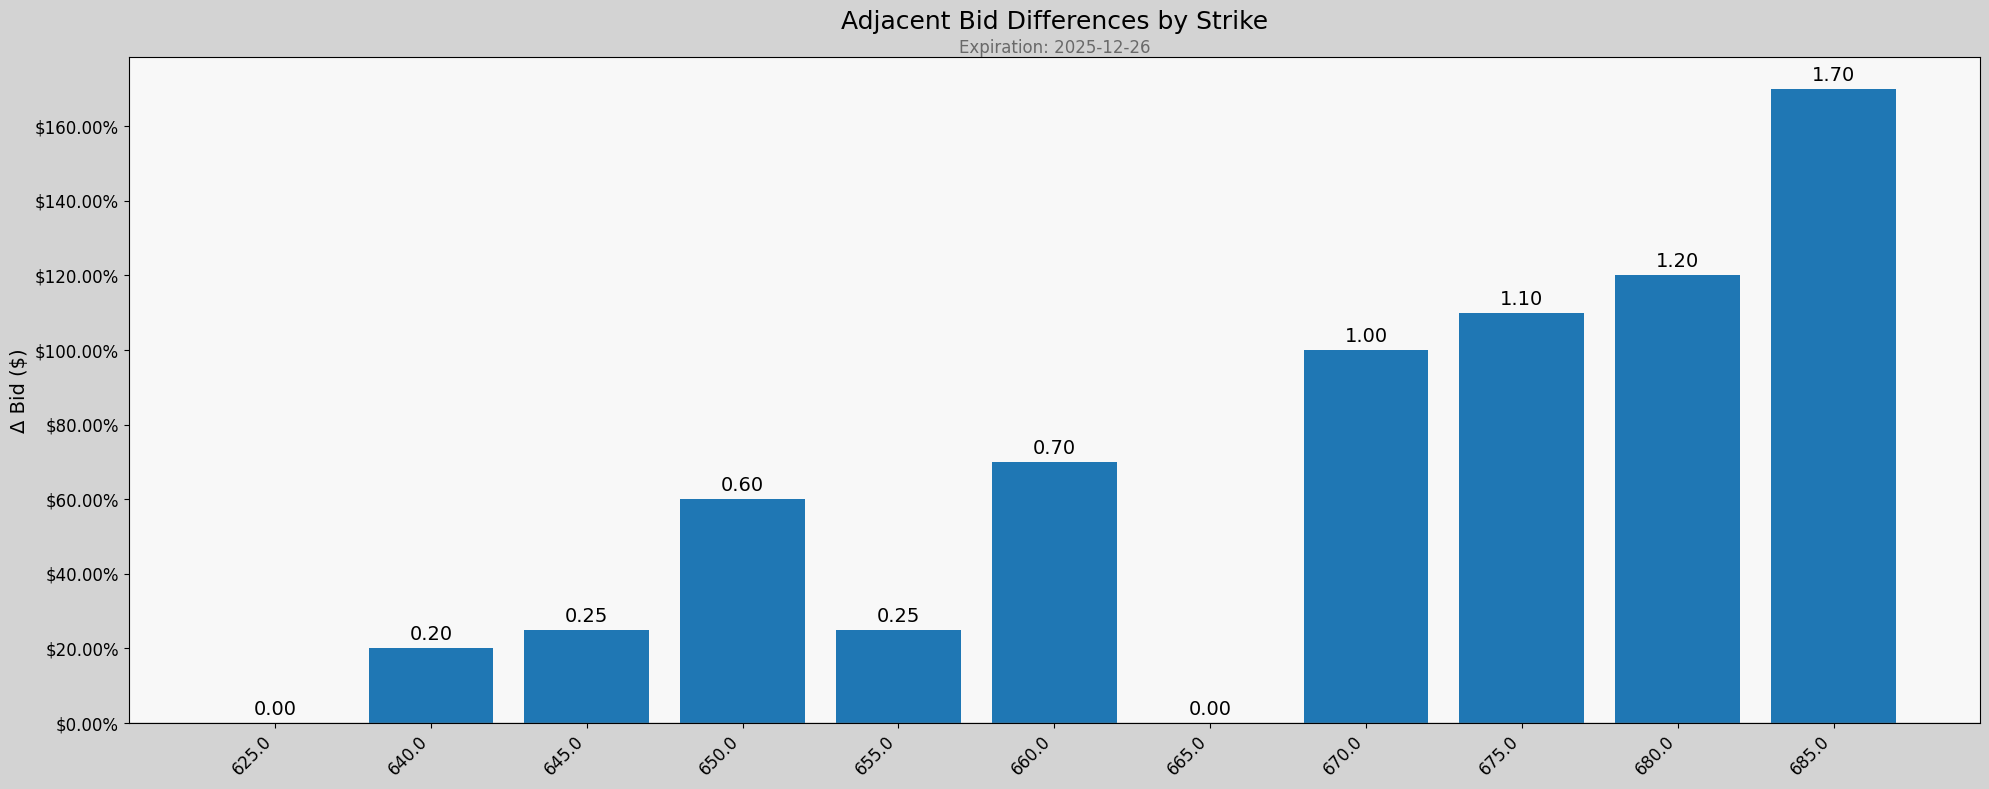

In [43]:
VAR = 'bid'
# ensure numeric and one row per strike
_tmp = puts_sub.copy()
_tmp['strike'] = pd.to_numeric(_tmp['strike'], errors='coerce')
_tmp[VAR] = pd.to_numeric(_tmp[VAR], errors='coerce')
bid_by_strike = (
    _tmp.dropna(subset=['strike', VAR])
        .sort_values('strike')
        .groupby('strike', as_index=True)[VAR].max()
)

# adjacent differences (current strike bid - previous strike bid)
diffs = bid_by_strike.diff().dropna()
diffs

from matplotlib.ticker import FuncFormatter

ax = plot.plot_bar(
    x=diffs.index.astype(str),
    y=diffs.values,
    style=cs,
    title=f"Adjacent {VAR.capitalize()} Differences by Strike",
    annotate=True,
    ylabel=f"Δ {VAR.capitalize()} ($)",
    subtitle=f"Expiration: {EXP_DATE}"
)

ax.axhline(0, color='gray', lw=1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.2%}'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout(); plt.show()

In [44]:
import numpy as np
import pandas as pd
from math import erf, log, sqrt

def _std_norm_cdf(x: np.ndarray) -> np.ndarray:
    """Standard normal CDF using erf (no external deps)."""
    return 0.5 * (1.0 + np.vectorize(erf)(x / sqrt(2.0)))

def all_put_credit_spreads_no_rename(puts_df: pd.DataFrame,
                                     min_oi: int = 0,
                                     min_vol: int = 0,
                                     underlying_price: float | None = None,
                                     assume_sigma: float = 0.25) -> pd.DataFrame:
    """
    Build all bull-put credit spreads from puts_df (same expiration) and compute
    return-on-risk plus comparison metrics (net delta, estimated profit probability,
    expected value per spread). Keeps original column names (suffixes added by self-merge).
    - underlying_price: if provided used to estimate profit probability; otherwise attempts
      to use columns 'underlying_price' or global `sec.last_close` (if present).
    - assume_sigma: fallback implied vol used if option volatility columns missing.
    """
    df = puts_df.copy()
    # ensure numeric
    for c in ['strike','bid','ask','last','theoretical','open_interest','volume','delta','volatility']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # liquidity filters
    if 'open_interest' in df.columns:
        df = df[df['open_interest'].fillna(0) >= min_oi]
    if 'volume' in df.columns:
        df = df[df['volume'].fillna(0) >= min_vol]
    if df.empty:
        return pd.DataFrame()

    # mid price: bid/ask -> last -> theoretical
    if {'bid','ask'}.issubset(df.columns):
        df['mid'] = (df['bid'].fillna(0) + df['ask'].fillna(0)) / 2.0
        zero_mid = df['mid'].eq(0)
        if 'last' in df.columns:
            df.loc[zero_mid & df['last'].notna(), 'mid'] = df.loc[zero_mid, 'last']
        if 'theoretical' in df.columns:
            df.loc[df['mid'].isna() & df['theoretical'].notna(), 'mid'] = df.loc[df['mid'].isna(), 'theoretical']
    else:
        src = 'last' if 'last' in df.columns else ('theoretical' if 'theoretical' in df.columns else None)
        df['mid'] = df[src] if src else np.nan

    # cross-join on expiration using self-merge; keep suffixes to distinguish legs
    m = df.merge(df, on='exp_date', suffixes=('_short','_long'), validate='many_to_many')

    # keep credit-put orientation: short (higher strike) > long (lower strike)
    m = m[m['strike_short'] > m['strike_long']].copy()
    if m.empty:
        return pd.DataFrame()

    # economics
    m['width'] = m['strike_short'] - m['strike_long']
    m['credit'] = (m['mid_short'] - m['mid_long']).clip(lower=0)
    m = m[m['credit'] > 0].copy()
    if m.empty:
        return pd.DataFrame()

    m['max_profit'] = m['credit']
    m['max_loss'] = (m['width'] - m['credit']).clip(lower=0)
    m = m[m['max_loss'] > 0].copy()
    if m.empty:
        return pd.DataFrame()

    m['breakeven'] = m['strike_short'] - m['credit']

    # net delta (if delta columns exist)
    if 'delta_short' in m.columns or 'delta_long' in m.columns:
        m['delta_short'] = m.get('delta_short', 0.0).astype(float)
        m['delta_long']  = m.get('delta_long', 0.0).astype(float)
        m['net_delta'] = m['delta_short'] + m['delta_long']
    else:
        m['net_delta'] = np.nan

    # attempt to determine underlying price
    S = None
    if underlying_price is not None:
        S = float(underlying_price)
    else:
        if 'underlying_price' in df.columns:
            S = float(df['underlying_price'].dropna().iloc[0])
        else:
            # try to use a globally defined `sec` object if present
            try:
                S = float(sec.last_close)  # sec from earlier cell
            except Exception:
                S = None

    # estimate sigma: prefer volatility_short then avg of both then fallback
    if 'volatility_short' in m.columns:
        sigma = m['volatility_short'].astype(float).replace(0, np.nan)
    else:
        vs = []
        if 'volatility_short' in m.columns: vs.append(m['volatility_short'])
        if 'volatility_long' in m.columns:  vs.append(m['volatility_long'])
        if vs:
            sigma = pd.concat(vs, axis=1).mean(axis=1)
        else:
            sigma = np.nan

    # compute probability of profit and expected value per spread
    today = pd.Timestamp.today().normalize()
    prob_list = []
    ev_list = []
    sigma_arr = []
    for idx, row in m.iterrows():
        BE = row['breakeven']
        max_loss = row['max_loss']
        credit = row['credit']

        # time to expiry in years
        try:
            exp = pd.to_datetime(row['exp_date'])
            days = max((exp.normalize() - today).days, 0)
            T = days / 365.0 if days > 0 else 0.0
        except Exception:
            T = 0.0

        # sigma for this pair
        s = np.nan
        if 'volatility_short' in m.columns and not np.isnan(row.get('volatility_short', np.nan)):
            s = float(row['volatility_short'])
        elif 'volatility_long' in m.columns and not np.isnan(row.get('volatility_long', np.nan)):
            s = float(row['volatility_long'])
        elif not np.isnan(sigma):
            s = float(sigma.loc[idx]) if isinstance(sigma, pd.Series) else float(sigma)
        else:
            s = float(assume_sigma)
        sigma_arr.append(s)

        if S is None or T <= 0 or s <= 0:
            # fallback: use deltas as heuristic for profit prob if present
            if 'delta_short' in row and not pd.isna(row['delta_short']):
                # approximate profit probability as 1 - |short_delta| (heuristic)
                prob = 1.0 - abs(float(row['delta_short']))
            else:
                prob = np.nan
        else:
            # Using lognormal approx with r=0: P(S_T > BE) = 1 - Phi( z )
            # where z = (ln(BE/S) + 0.5*s^2*T) / (s*sqrt(T))
            try:
                z = (log(BE / S) + 0.5 * (s**2) * T) / (s * sqrt(T))
                prob = 1.0 - _std_norm_cdf(z)
            except Exception:
                prob = np.nan

        prob_list.append(prob)
        # expected value per contract (USD): win -> receive credit, lose -> pay max_loss (approx)
        if pd.isna(prob):
            ev = np.nan
        else:
            ev = prob * credit - (1.0 - prob) * max_loss
        ev_list.append(ev)

    m['est_sigma'] = sigma_arr
    m['prob_profit'] = prob_list
    m['expected_value'] = ev_list
    # risk/return metrics
    m['risk_return'] = m['max_loss'] / m['max_profit']      # lower is better
    m['return_on_risk'] = m['max_profit'] / m['max_loss']  # reward per unit risk
    # m['credit_per_risk'] = m['credit'] / m['max_loss']

    # s['credit_pct'] = s['cons_credit'] / s['width']            # credit as fraction of width
    # s['ev_per_risk'] = s['expected_value'] / s['max_loss']    # may be negative
    # s['ev_per_capital'] = s['expected_value'] / s['cons_max_loss']  # expected $ / $ risk
    # s['prob_profit'] = pd.to_numeric(s.get('prob_profit'), errors='coerce').fillna(0)
    # s['return_on_risk'] = pd.to_numeric(s.get('return_on_risk'), errors='coerce').fillna(0)
    # s['net_delta'] = pd.to_numeric(s.get('net_delta'), errors='coerce')
    # s['score'] = (
    #       s['prob_profit'] * 100.0           # reward high probability
    #     + s['return_on_risk'] * 50.0         # reward good return per risk
    #     + s['credit_pct'] * 200.0            # reward getting large fraction of width as credit
    #     - (s['cons_max_loss'] / 100.0)        # penalize large absolute max loss
    #     - s['net_delta'].abs() * 10.0        # prefer lower directional exposure
    # )

    # # filters you might use (example)
    # f = (
    #     (s['cons_credit'] > 0) &
    #     (s['cons_max_loss'] > 0) &
    #     (s['prob_profit'] >= 0.60) &        # at least 60% chance to keep credit
    #     (s['credit_pct'] >= 0.05) &         # credit at least 5% of width
    #     (s['cons_max_loss'] <= 2000) &      # limit absolute risk (adjust)
    #     (s['net_delta'].abs() <= 0.35)      # remove overly directional trades
    # )


    # select useful columns (original columns kept with suffixes)
    cols = [
        'exp_date',
        'strike_short','bid_short','delta_short','volatility_short',
        'strike_long','ask_long','delta_long','volatility_long',
        'width','credit','max_profit','max_loss','breakeven','net_delta',
        'prob_profit','expected_value','est_sigma','return_on_risk','risk_return'
    ]
    cols = [c for c in cols if c in m.columns]
    out = m[cols].reset_index(drop=True).sort_values(['expected_value','return_on_risk'], ascending=[False, True])
    return out

# usage: compute and display
spreads = all_put_credit_spreads_no_rename(puts_sub, min_oi=0, min_vol=0)
display(spreads.head(50).sort_values('return_on_risk', ascending=False))
# ...existing code...


,exp_date,strike_short,bid_short,delta_short,volatility_short,strike_long,ask_long,delta_long,volatility_long,width,credit,max_profit,max_loss,breakeven,net_delta,prob_profit,expected_value,est_sigma,return_on_risk,risk_return
61,2025-12-26,685.0,7.00,-0.443758,0.1484,680.0,8.5,-0.370939,0.1537,5.0,1.750,1.750,3.250,683.250,-0.814697,0.556242,-0.468790,0.1484,0.538462,1.857143
60,2025-12-26,685.0,7.00,-0.443758,0.1484,675.0,7.5,-0.311812,0.1644,10.0,2.850,2.850,7.150,682.150,-0.755570,0.556242,-1.587580,0.1484,0.398601,2.508772
59,2025-12-26,685.0,7.00,-0.443758,0.1484,670.0,6.1,-0.255688,0.1684,15.0,4.100,4.100,10.900,680.900,-0.699446,0.556242,-2.556370,0.1484,0.376147,2.658537
16,2025-12-26,660.0,2.00,-0.183409,0.1902,655.0,2.8,-0.130084,0.1790,5.0,1.300,1.300,3.700,658.700,-0.313493,0.816591,0.382955,0.1902,0.351351,2.846154
58,2025-12-26,685.0,7.00,-0.443758,0.1484,665.0,5.2,-0.208706,0.1736,20.0,5.050,5.050,14.950,679.950,-0.652464,0.556242,-3.825160,0.1484,0.337793,2.960396
40,2025-12-26,675.0,4.10,-0.311812,0.1644,670.0,6.1,-0.255688,0.1684,5.0,1.250,1.250,3.750,673.750,-0.567500,0.688188,-0.309060,0.1644,0.333333,3.000000
49,2025-12-26,680.0,5.30,-0.370939,0.1537,670.0,6.1,-0.255688,0.1684,10.0,2.350,2.350,7.650,677.650,-0.626627,0.629061,-1.359390,0.1537,0.307190,3.255319
50,2025-12-26,680.0,5.30,-0.370939,0.1537,675.0,7.5,-0.311812,0.1644,5.0,1.100,1.100,3.900,678.900,-0.682751,0.629061,-0.754695,0.1537,0.282051,3.545455
56,2025-12-26,685.0,7.00,-0.443758,0.1484,655.0,2.8,-0.130084,0.1790,30.0,6.600,6.600,23.400,678.400,-0.573842,0.556242,-6.712740,0.1484,0.282051,3.545455
48,2025-12-26,680.0,5.30,-0.370939,0.1537,665.0,5.2,-0.208706,0.1736,15.0,3.300,3.300,11.700,676.700,-0.579645,0.629061,-2.264085,0.1537,0.282051,3.545455


<Axes: xlabel='credit', ylabel='expected_value'>

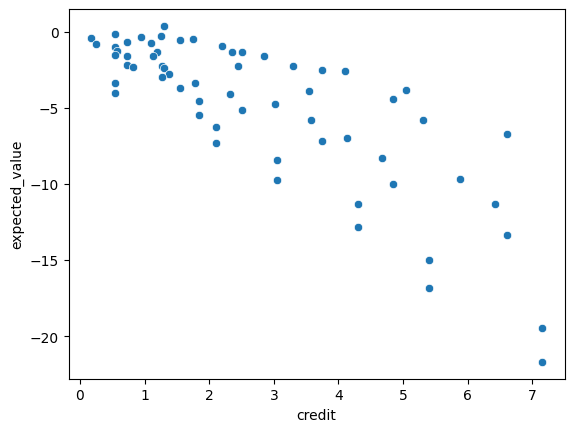

In [45]:
sns.scatterplot(data=spreads, x='credit', y='expected_value')

# Chain History

In [46]:
ch = ChainHistory(ticker="IVV", start="2024-09-05", end="2025-10-17", chunk_size=15, refresh=False)
hist = ch.history
trd = ch.trades

hist_atm = ch.get_timeseries_by_delta(delta_target=0.5, delta_tolerance=0.1, trades=True) 
dte_30 = ch.get_n_dte_timeseries(n_days=30, trades=True)
delta_25_dte_30 = ch.get_time_series_n_dte_by_delta(n_days=30, delta_target=0.25, delta_tolerance=0.1, trades=True)

pcs = ch.get_pc_spread(df=delta_25_dte_30, value='volatility')
pcs_rank = ch.get_pc_spread_rank(df=pcs)
pcs_rolling = ch.get_pc_spread_rolling(df=pcs, window=20)

ivol_rank = ch.get_ivol_rank(df=pcs)

iv_rank, vw_iv_percentile = ch.get_iv_rank(df=hist_atm)
iv_rank_roll = ch.get_iv_rank_rolling(df=hist_atm, window=20)

Loading existing data from C:\Users\msands\OneDrive\Documents\data\EODHD Options Chain History\\IVV_Chain_History_2024-09-05_2025-10-17.pkl


In [47]:
cols_view = ['tradetime', 'contract', 'underlying_symbol', 'expiration_type', 'exp_date',  'type', 'strike','dte', 'delta', 'volatility',  'volume']
cols_greeks = ['delta', 'gamma', 'theta', 'vega', 'rho']
cols_trade = [ 'open', 'high', 'low', 'last', 'last_size', 'change', 'pctchange', 'previous', 'previous_date', 'bid', 'bid_date', 'bid_size', 'ask', 'ask_date', 'ask_size','moneyness', 
              'volume', 'volume_change', 'volume_pctchange', 'open_interest','open_interest_change', 'open_interest_pctchange', 'theoretical', 'vol_oi_ratio']

In [48]:
ch.history

,contract,underlying_symbol,exp_date,expiration_type,type,strike,exchange,currency,open,high,...,theoretical,delta,gamma,theta,vega,rho,tradetime,vol_oi_ratio,dte,midpoint
0,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,120.70,0.843066,0.001717,-0.076824,0.999999,0.999999,2024-09-19,0.00,272.0,120.70
1,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,120.70,0.844533,0.001715,-0.075791,0.999999,0.999999,2024-09-19,0.00,274.0,120.70
2,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,122.65,0.841629,0.001686,-0.077764,0.999999,0.999999,2024-09-19,0.00,275.0,122.65
3,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,117.30,0.832177,0.001788,-0.078489,0.999999,0.999999,2024-09-19,0.00,276.0,117.30
4,IVV251219C00465000,IVV,2025-12-19,monthly,call,465.0,AMEX,USD,0.00,0.00,...,123.20,0.849752,0.001665,-0.074294,0.999999,0.999999,2024-09-19,0.00,277.0,123.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208045,IVV251017P00665000,IVV,2025-10-17,monthly,put,665.0,AMEX,USD,1.54,1.54,...,3.95,-0.542683,0.046345,-0.999999,0.137838,-0.008674,2025-10-16,0.67,1.0,3.95
208046,IVV251017P00668000,IVV,2025-10-17,monthly,put,668.0,AMEX,USD,3.37,3.37,...,5.35,-0.703656,0.047163,-0.999999,0.120128,-0.010672,2025-10-16,0.00,1.0,5.35
208047,IVV251017P00669000,IVV,2025-10-17,monthly,put,669.0,AMEX,USD,2.45,2.45,...,6.05,-0.751577,0.044404,-0.999999,0.110033,-0.011129,2025-10-16,0.17,1.0,6.05
208048,IVV251017P00674000,IVV,2025-10-17,monthly,put,674.0,AMEX,USD,8.68,8.68,...,10.15,-0.942594,0.018413,-0.336249,0.039744,-0.009759,2025-10-16,0.20,1.0,10.15


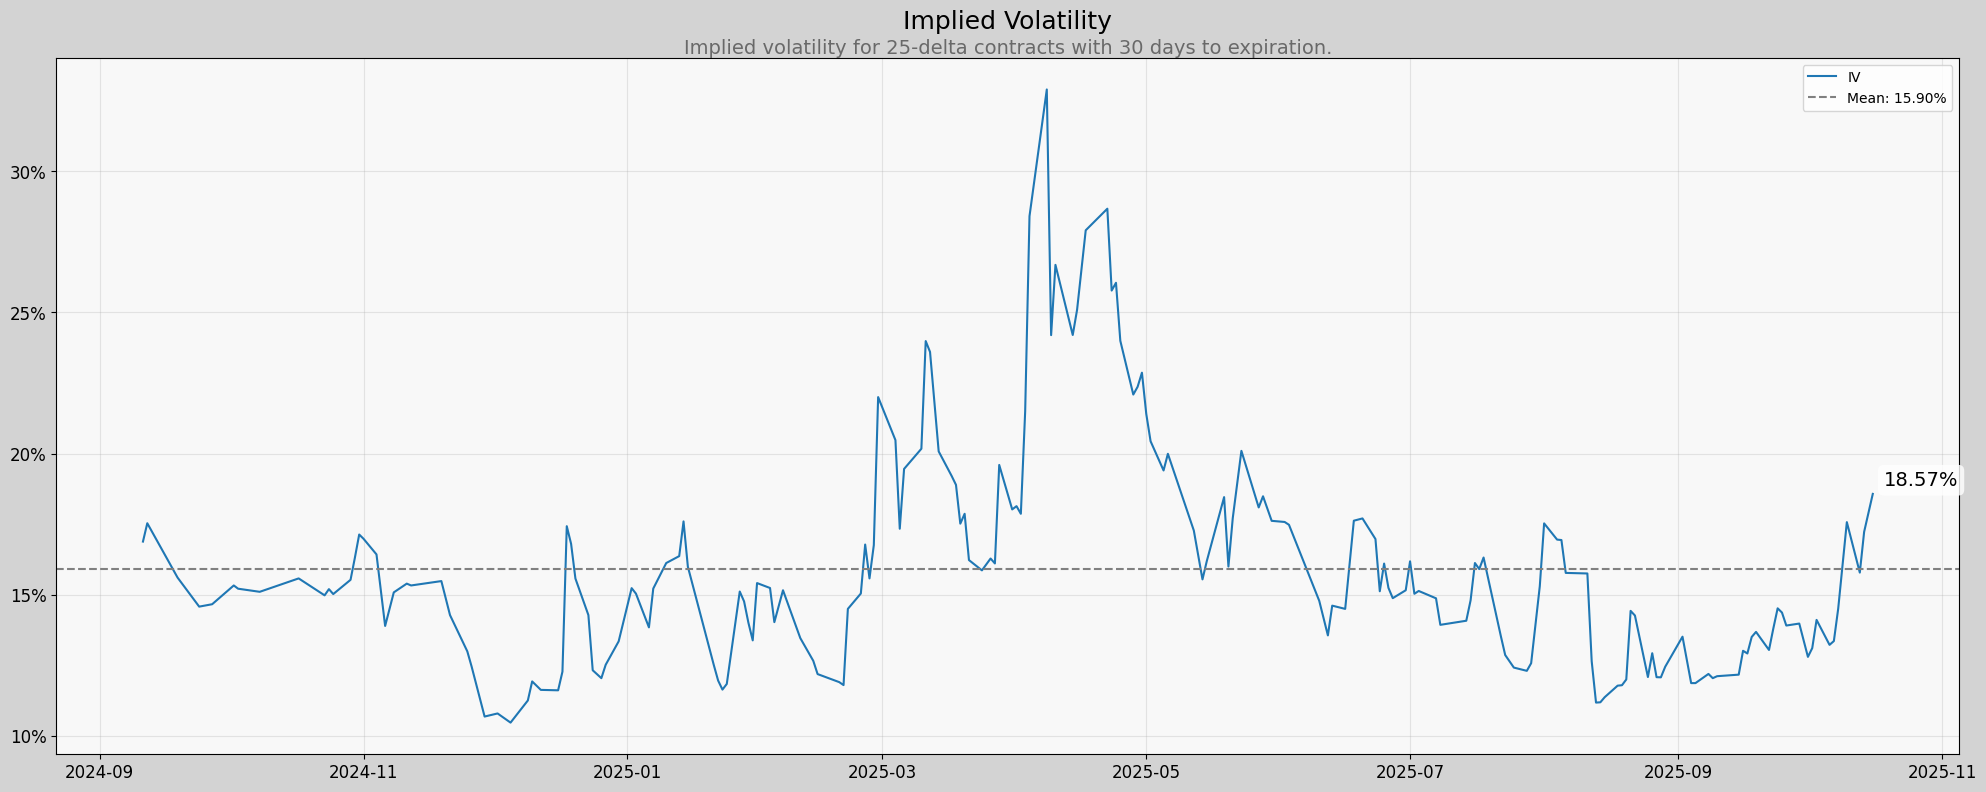

In [49]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['ivol'],
    date_axis=False,
    style=cs,
    title="Implied Volatility",
    subtitle="Implied volatility for 25-delta contracts with 30 days to expiration.",
    style_kwargs={"subtitle_size": 14},
    grid=True,
    label="IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)
ax.axhline(y=pcs['ivol'].mean(), color='gray', linestyle='--', label=f'Mean: {pcs["ivol"].mean():.2%}')
import matplotlib.pyplot as plt
plt.legend()

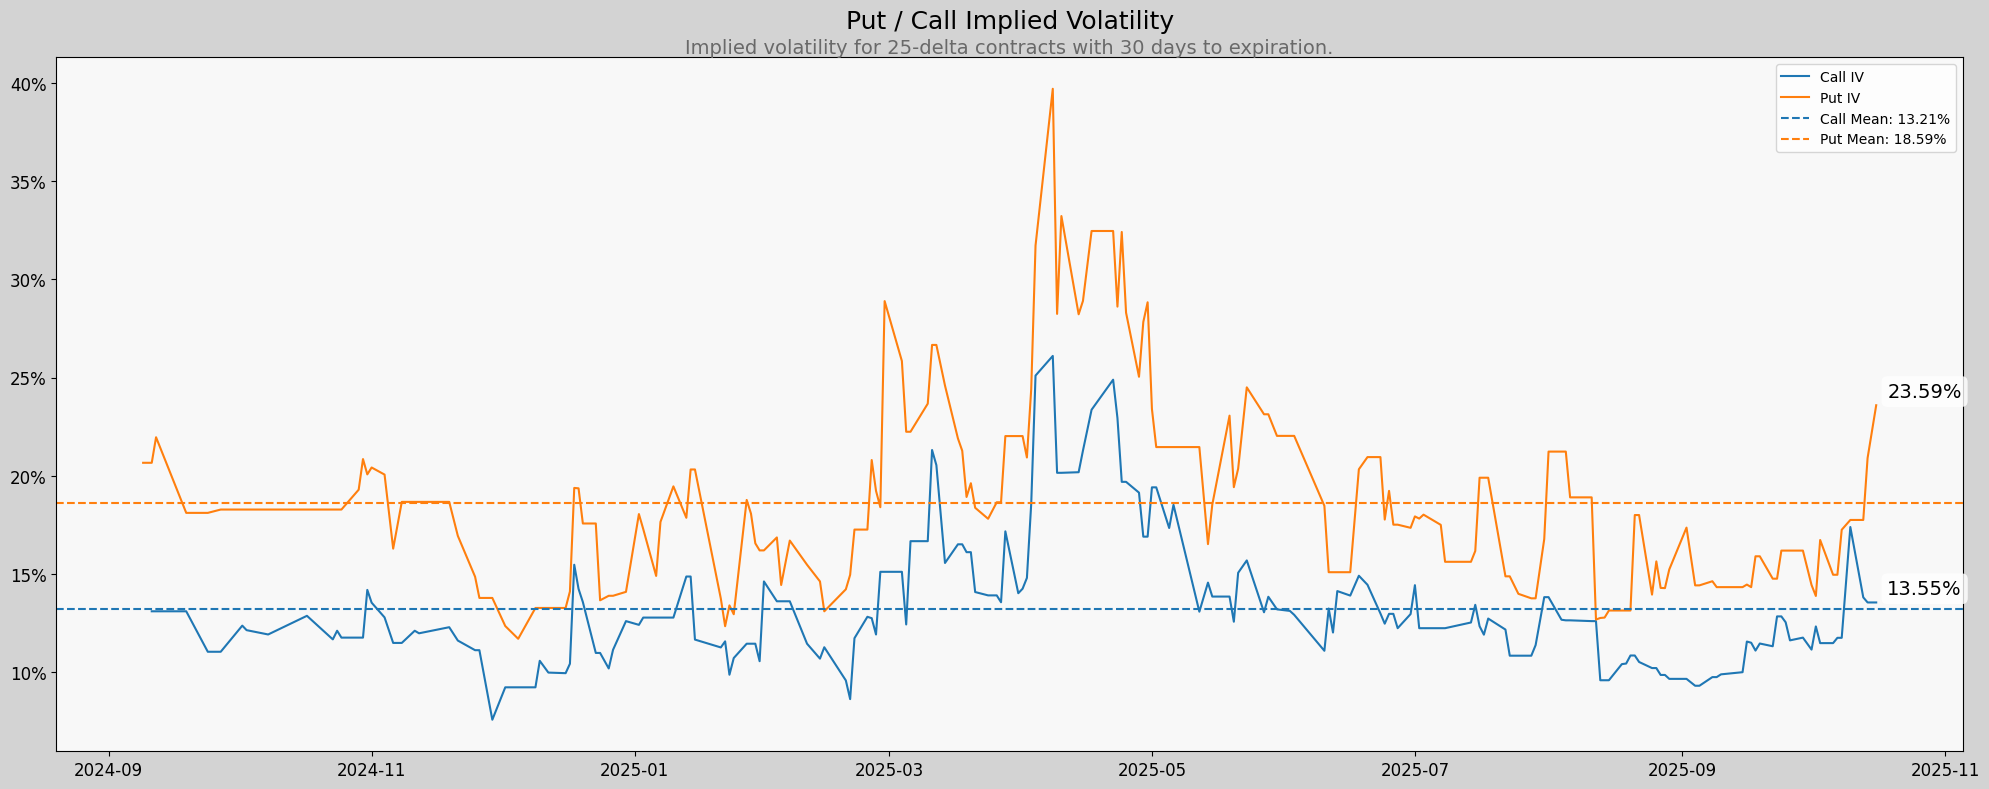

In [50]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['call_vol'],
    date_axis=False,
    style=cs,
    title="Put / Call Implied Volatility",
    subtitle="Implied volatility for 25-delta contracts with 30 days to expiration.",
    style_kwargs={"subtitle_size": 14},
    grid=True,
    label="Call IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
)
plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['put_vol'],
    ax=ax,
    date_axis=False,
    style=cs,
    label="Put IV",
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    color="tab:orange",
)
ax.axhline(y=pcs['call_vol'].mean(), color='tab:blue', linestyle='--', label=f'Call Mean: {pcs["call_vol"].mean():.2%}')
ax.axhline(y=pcs['put_vol'].mean(), color='tab:orange', linestyle='--', label=f'Put Mean: {pcs["put_vol"].mean():.2%}')
ax.legend()

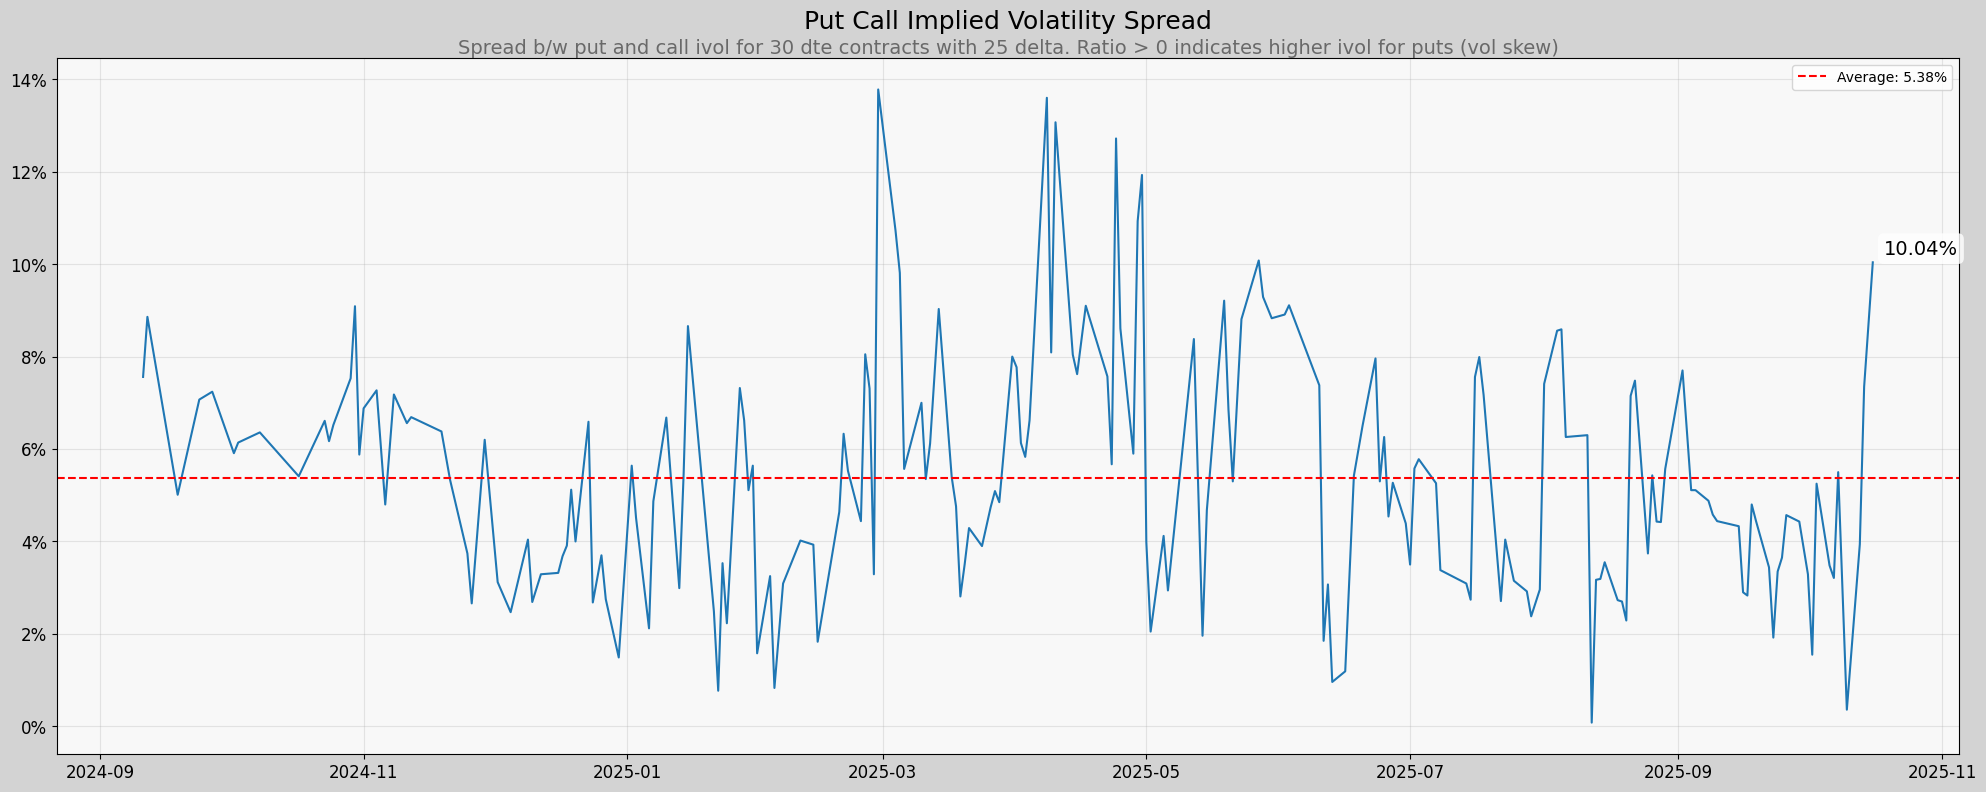

In [51]:
ax = plot.plot_line(
    x=pcs['tradetime'],
    y=pcs['pc_spread'],
    date_axis=False,
    style=cs,
    title="Put Call Implied Volatility Spread",
    subtitle="Spread b/w put and call ivol for 30 dte contracts with 25 delta. Ratio > 0 indicates higher ivol for puts (vol skew)",
    style_kwargs = {"subtitle_size": 14},
    grid=True,
    annotate_last=True,
    annotate_last_fmt="{:.2%}",
    y_fmt="{:,.0%}",
    legend=True
)
ax.axhline(pcs['pc_spread'].mean(), color='red', linestyle='--', label=f'Average: {pcs["pc_spread"].mean():.2%}')
plt.legend()

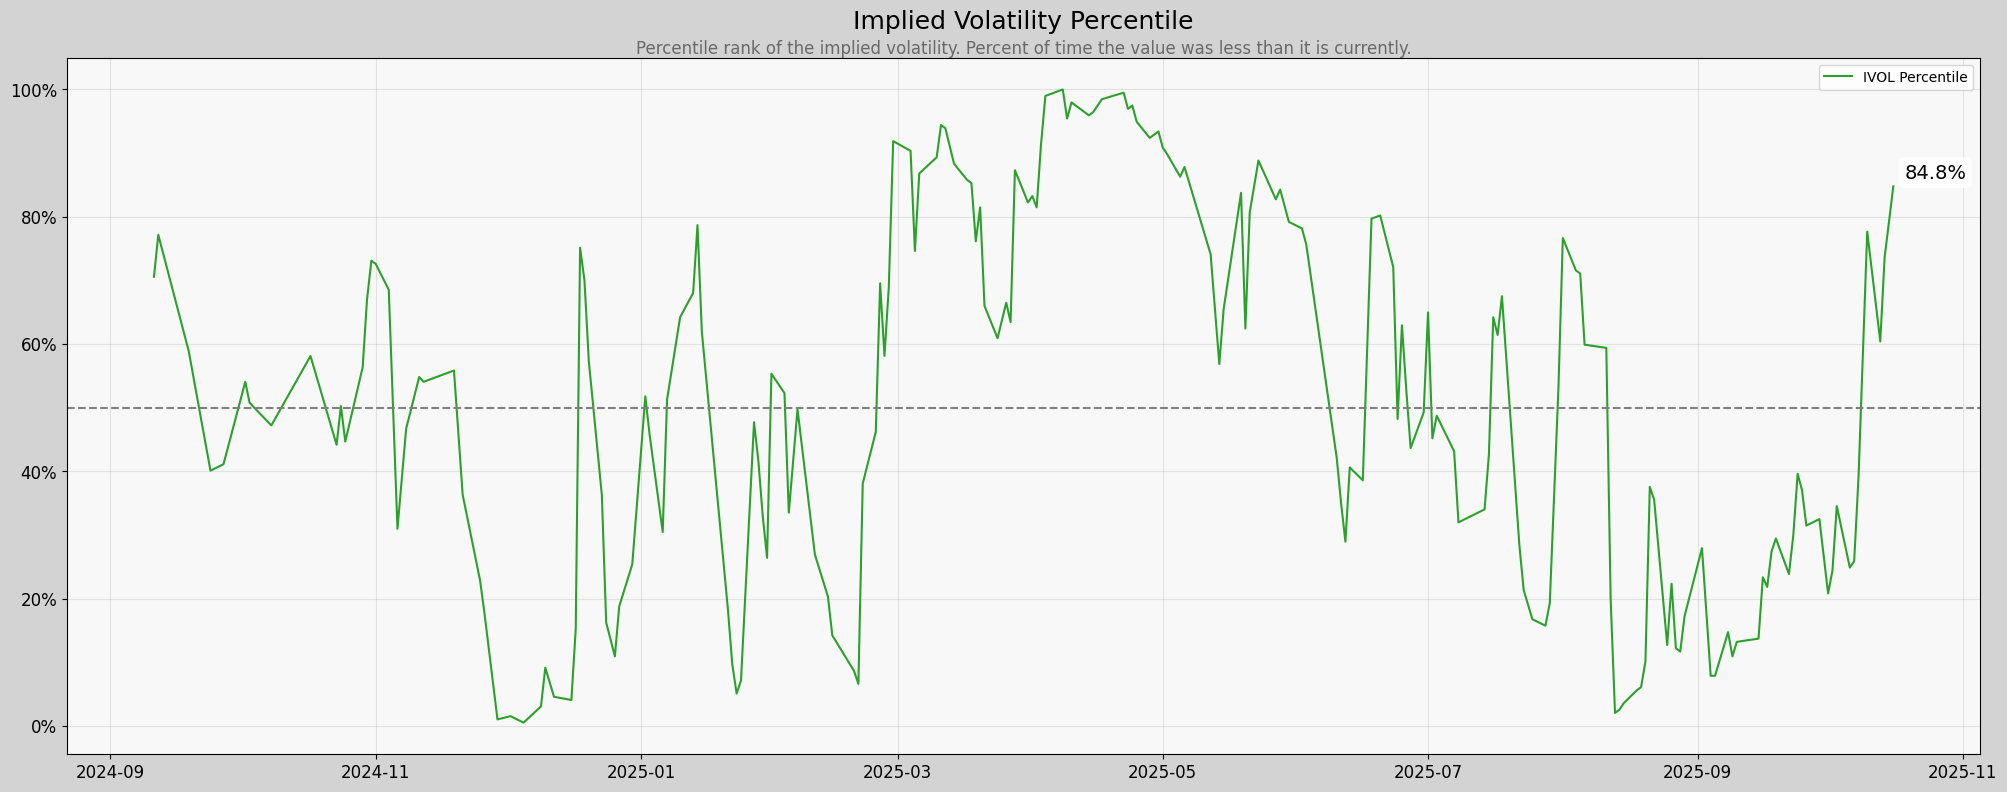

In [52]:
ax = plot.plot_line(
    x=ivol_rank['tradetime'],
    y=ivol_rank['ivol_percentile'],
    date_axis=False,
    style=cs,
    title="Implied Volatility Percentile",
    subtitle="Percentile rank of the implied volatility. Percent of time the value was less than it is currently.",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="IVOL Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.axhline(y=.5, color='gray', linestyle='--', )
ax.legend()

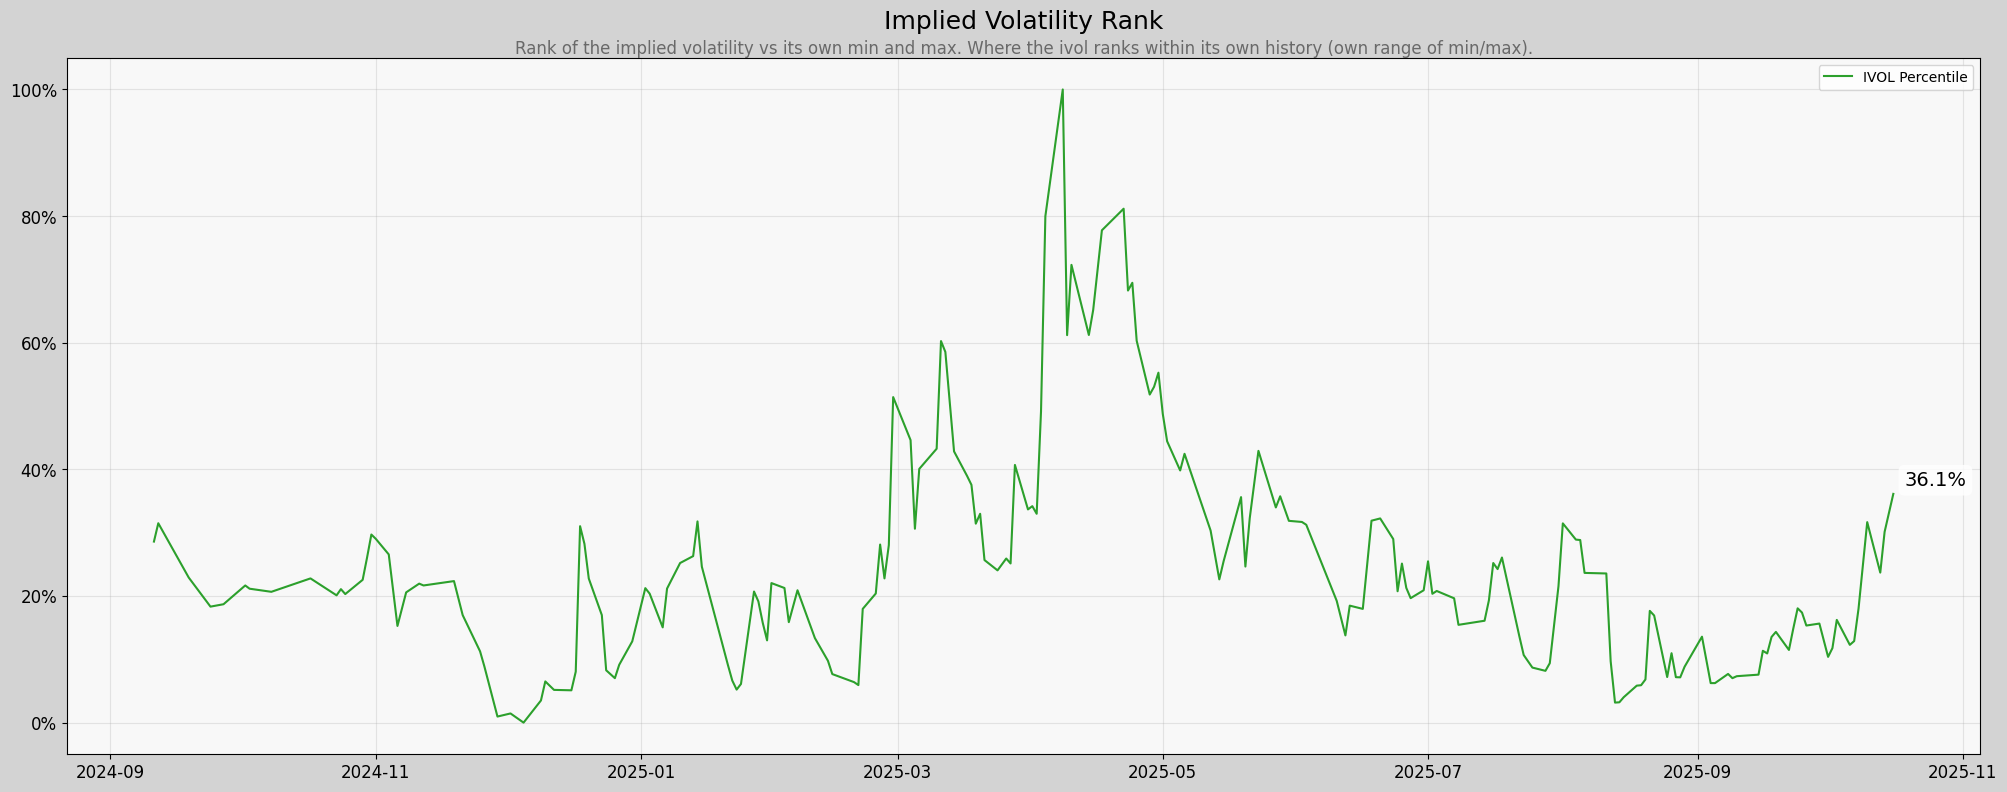

In [53]:
ax = plot.plot_line(
    x=ivol_rank['tradetime'],
    y=ivol_rank['ivol_rank'],
    date_axis=False,
    style=cs,
    title="Implied Volatility Rank",
    subtitle="Rank of the implied volatility vs its own min and max. Where the ivol ranks within its own history (own range of min/max).",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="IVOL Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.legend()

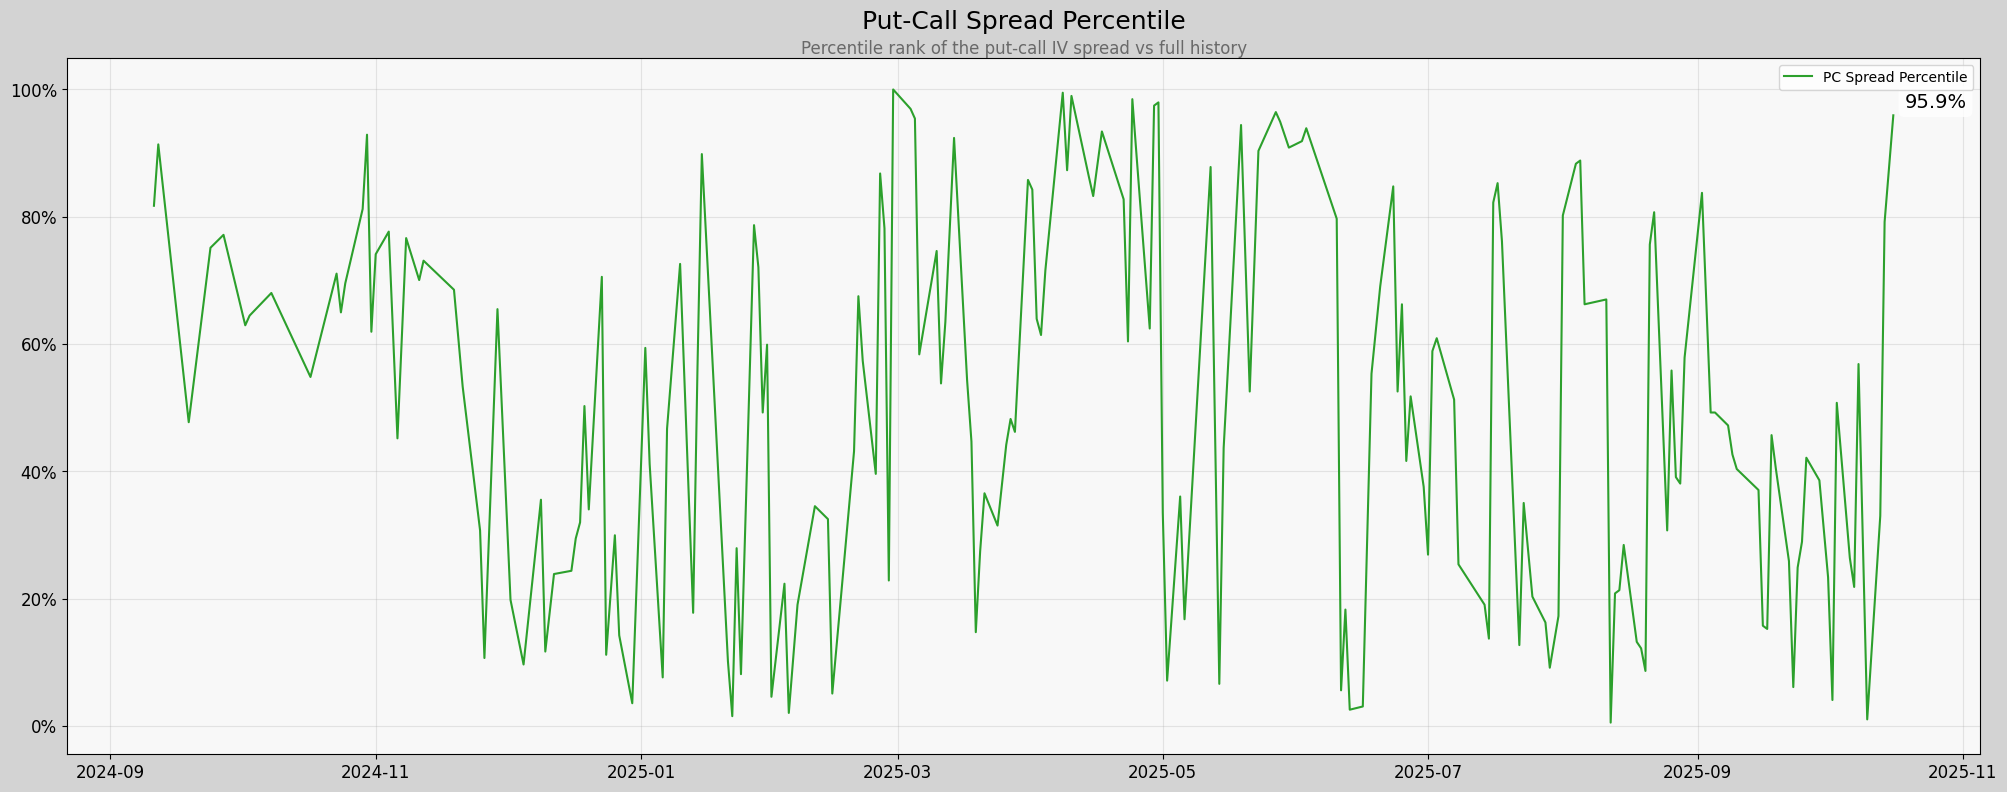

In [54]:
ax = plot.plot_line(
    x=pcs_rank['tradetime'],
    y=pcs_rank['pc_spread_percentile'],
    date_axis=False,
    style=cs,
    title="Put-Call Spread Percentile",
    subtitle="Percentile rank of the put-call IV spread vs full history",
    style_kwargs={"subtitle_size": 12},
    grid=True,
    label="PC Spread Percentile",
    annotate_last=True,
    annotate_last_fmt="{:.1%}",
    y_fmt="{:.0%}",
    color="tab:green",
)
ax.legend()

In [55]:
# implied_move_ts = ch.get_implied_move_timeseries()

# res = implied_move_ts[implied_move_ts['exp_date']=='2025-12-19']

# ax = plot.plot_line(
#     x=res['tradetime'],
#     y=res['expected_move_pct'],
#     date_axis=False,
#     style=cs,
#     title="Implied Move in Underlying",
#     subtitle="",
#     style_kwargs={"subtitle_size": 12},
#     grid=True,
#     label="% Change",
#     annotate_last=True,
#     annotate_last_fmt="{:.1%}",
#     y_fmt="{:.0%}",
#     color="tab:green",
# )
# ax.legend()

display(ch.get_implied_move_latest())

type,tradetime,exp_date,dte,call,put,ivol,undr_last_price,expected_move_usd,expected_move_pct
0,2025-10-06,2025-12-19,74.0,0.1470,0.1337,0.14035,687.26,43.431308,0.063195
1,2025-10-08,2026-01-16,100.0,0.1484,0.1408,0.14460,687.26,52.016716,0.075687
2,2025-08-28,2026-02-20,176.0,0.1720,0.1384,0.15520,687.26,74.066647,0.107771
3,2025-09-04,2026-03-20,197.0,0.1473,0.1457,0.14650,687.26,73.968255,0.107628
4,2025-09-23,2026-04-17,206.0,0.1644,0.1430,0.15370,687.26,79.356428,0.115468
5,2025-10-15,2026-06-18,246.0,0.1757,0.1550,0.16535,687.26,93.292426,0.135745
6,2025-10-01,2027-01-15,471.0,0.1695,0.1672,0.16835,687.26,131.431120,0.191239


# Evaluate Chain (Strategies)

In [56]:
chain = Chain(ticker = 'SPY', max_expiration="2026-01-31")
calls = chain.calls
puts = chain.puts
atm = chain.atm    
atm_calls = chain.atm_calls
atm_puts = chain.atm_puts

Total records to fetch: 4470
Fetched 1000 rows at offset 0
Fetched 1000 rows at offset 1000
Fetched 1000 rows at offset 2000
Fetched 1000 rows at offset 3000
Fetched 470 rows at offset 4000
